In [39]:
# os
import os

# データ整形用
import pandas as pd

# ベイズ最適化
import optuna

# 構造学習用
from causalnex.structure.notears import from_pandas_lasso
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

# ベイジアンネットワーク
from causalnex.network import BayesianNetwork
from causalnex.inference import InferenceEngine

# AUCの計算用
from sklearn.metrics import roc_auc_score
from causalnex.evaluation import classification_report, roc_auc
from sklearn.model_selection import train_test_split


# 可視化用
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import networkx as nx

In [40]:
data = pd.read_excel('../data/231021-1110_AI用qPCRデータ.xlsx', header=1, index_col=0)
data = data.dropna()
data = data.reset_index(drop=True)
data.shape

(211, 33)

In [41]:
# 平均0, 分散1の標準化
scaler = StandardScaler()
norm_data_array = scaler.fit_transform(data)
norm_data = pd.DataFrame(norm_data_array, columns=data.columns)
norm_data.head(3)

,glk,agp,yihX,pgm,ptsG,malx,crr,galM,yihR,yeaD,...,tpiA,gapA,pgk,gpmA,ytjc,gpmM,eno,pykF,pykA,ppsA
0,-0.478000,-0.145310,-0.186724,-0.126510,-0.296711,-0.196438,-0.139036,-0.099555,-0.150187,-0.270711,...,-0.304500,0.040025,-1.144075,0.233070,-0.251672,-0.181602,-0.634371,-0.893224,-0.429545,-0.422568
1,-0.383090,-0.128682,-0.145902,-0.489821,-0.295543,-0.142752,-0.133647,-0.091603,-0.063683,-0.124194,...,-0.152559,0.058741,-1.142809,0.286622,-0.169224,0.018884,-0.543704,-0.337397,-0.029556,-0.000408
2,-0.383244,-0.603811,-0.145725,-0.490193,-0.202170,-0.196047,0.304820,-0.097057,-0.150002,0.169103,...,-0.153226,0.047084,-1.135013,0.269307,-0.167799,0.018553,-0.361239,-0.327326,-0.023438,0.014527


In [42]:
norm_data.describe()

,glk,agp,yihX,pgm,ptsG,malx,crr,galM,yihR,yeaD,...,tpiA,gapA,pgk,gpmA,ytjc,gpmM,eno,pykF,pykA,ppsA
count,2.110000e+02,2.110000e+02,211.000000,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,211.000000,...,2.110000e+02,2.110000e+02,211.000000,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02,2.110000e+02
mean,5.051252e-17,2.525626e-17,0.000000,3.367501e-17,1.683751e-17,1.683751e-17,1.762676e-16,-1.683751e-17,-5.051252e-17,0.000000,...,-9.260628e-17,-1.683751e-17,0.000000,-8.418753e-17,4.209376e-17,4.209376e-17,-8.418753e-18,1.852126e-16,1.852126e-16,3.262267e-17
std,1.002378e+00,1.002378e+00,1.002378,1.002378e+00,1.002378e+00,1.002378e+00,1.002378e+00,1.002378e+00,1.002378e+00,1.002378,...,1.002378e+00,1.002378e+00,1.002378,1.002378e+00,1.002378e+00,1.002378e+00,1.002378e+00,1.002378e+00,1.002378e+00,1.002378e+00
min,-4.780000e-01,-7.510124e-01,-0.186724,-4.903453e-01,-3.631808e-01,-2.094162e-01,-4.700052e-01,-6.296648e-01,-1.609539e-01,-0.378197,...,-4.224254e-01,-1.015724e+00,-1.144075,-1.067932e+00,-3.181826e-01,-3.744737e-01,-7.050315e-01,-1.434112e+00,-7.954733e-01,-7.980027e-01
25%,-2.040228e-01,-4.411327e-01,-0.145927,-3.056620e-01,-2.052156e-01,-1.788333e-01,-1.394756e-01,-3.980777e-01,-1.532378e-01,-0.267103,...,-3.023720e-01,-4.969632e-01,-0.488021,-5.698881e-01,-1.693809e-01,-1.812925e-01,-3.672446e-01,-3.381452e-01,-4.185925e-01,-6.289921e-01
50%,-1.978871e-01,-1.276089e-01,-0.092282,-1.223859e-01,-2.018352e-01,-1.778345e-01,-1.339446e-01,-9.545939e-02,-1.377802e-01,-0.264006,...,-1.525370e-01,-4.883954e-01,-0.478193,-5.581969e-01,-1.666925e-01,-1.759255e-01,-3.576868e-01,-3.292493e-01,-3.377686e-02,-4.146108e-01
75%,1.700407e-01,-1.204326e-01,-0.090436,-1.112816e-01,-1.896874e-02,-1.413917e-01,-1.289496e-01,-8.750551e-02,-1.126858e-01,-0.116383,...,1.393212e-01,7.340577e-02,0.190055,2.901932e-01,-4.921981e-03,1.910111e-02,2.121459e-03,7.628855e-01,-1.964333e-02,2.027243e-02
max,1.121691e+01,9.519742e+00,13.899702,1.181735e+01,1.132062e+01,9.053277e+00,1.376905e+01,9.321031e+00,1.246998e+01,8.845431,...,9.325466e+00,7.825172e+00,4.411099,5.472512e+00,1.016051e+01,1.220333e+01,1.083832e+01,7.568908e+00,1.162761e+01,5.953575e+00


X (DataFrame) – input data.
beta (float) – Constant that multiplies the lasso term.
max_iter (int) – max number of dual ascent steps during optimisation.
h_tol (float) – exit if h(W) < h_tol (as opposed to strict definition of 0).
w_threshold (float) – fixed threshold for absolute edge weights.

### データの離散化
#### 2値分類（中央値で分類）

In [43]:
# Discretize the features
# 中央値を基準に増加と制御を分類
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
discretised_data = discretizer.fit_transform(norm_data.iloc[:, :])

# Creating a new DataFrame for the discretized data
discretised_data = pd.DataFrame(discretised_data, columns=data.columns)

discretised_data = discretised_data.replace({0: 'high', 1: 'low'})
discretised_data

/home/yarita/.local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


,glk,agp,yihX,pgm,ptsG,malx,crr,galM,yihR,yeaD,...,tpiA,gapA,pgk,gpmA,ytjc,gpmM,eno,pykF,pykA,ppsA
0,high,high,high,high,high,high,high,high,high,high,...,high,high,high,high,high,high,high,high,high,high
1,high,high,high,high,high,high,high,high,high,high,...,high,high,high,high,high,high,high,high,high,high
2,high,high,high,high,high,high,high,high,high,high,...,high,high,high,high,high,high,high,high,high,high
3,high,high,high,high,high,high,high,high,high,high,...,high,high,high,high,high,high,high,high,high,high
4,high,high,high,high,high,high,high,high,high,high,...,high,high,high,high,high,high,high,high,high,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,high,high,high,high,high,high,high,high,high,high,...,high,high,high,high,high,high,high,high,high,high
207,high,high,high,high,high,high,high,high,high,high,...,high,high,high,high,high,high,high,high,high,high
208,high,high,high,high,high,high,high,high,high,high,...,high,high,high,high,high,high,high,high,high,high
209,high,high,low,low,low,low,high,high,high,low,...,high,high,high,high,high,high,high,low,high,high


#### 注意点
- w_thresholdの探索範囲: 0.0 - 5.0など，maxを大きい値にするとベイジアンネットワークの構築ができず，エラーが出てしまうので，1つの連結されたネットワークである必要があるので，1.0にしている．1.0であれば，1つの連結されたネットワークになるので，エラーが出ない．

In [44]:
# # ベイズ最適化
# def objective(trial):
#     # train, test = train_test_split(discretised_data, train_size=0.8, random_state=42)
    
#     # max_iter = trial.suggest_int('max_iter', 100, 1000)
#     # w_threshold = trial.suggest_float('w_threshold', 1e-4, 0.5)
#     beta = trial.suggest_float('beta', 1e-8, 1, log=True)  # ログスケールでlassoの値を探索(探索範囲は広め)

#     # NOTEARSアルゴリズムを用いて構造学習を実施
#     # ここでfrom_pandasのパラメータをOptunaのtrialを通してチューニング
#     sm, loss_values = from_pandas_lasso(norm_data,
#                         #    max_iter=max_iter,
#                         #    w_threshold=w_threshold,
#                            beta=beta
#                            )

#     # bn = BayesianNetwork(sm)

#     # bn = bn.fit_node_states(norm_data)
#     # bn = bn.fit_cpds(train)

#     # # AUCを計算
#     # _, auc = roc_auc(bn, test, "pgi")

#     # # 損失関数をスコアとして，最小化する

#     # print("\nAUC: {}".format(auc))

#     return loss_values[-1]

# # スコア(loss_values)を最小化
# study = optuna.create_study(direction='minimize')
# # 最大化
# # study = optuna.create_study(direction='maximize')

# # 100回の試行で最適化
# study.optimize(objective, n_trials=100)
# # ログ非表示
# # optuna.logging.set_verbosity(optuna.logging.WARNING)

# # 最適なハイパーパラメータを出力
# best_params = study.best_params

In [45]:
# ベストなlasso_betaの値
best_params = {'beta': 0.00025281522372170768}
best_params

{'beta': 0.0002528152237217077}

[1.6323177998834733, 1.8334402303634922, 2.0010901053778882, 2.036894636572399, 2.0860968526903547, 2.1960772954262855, 2.3948529692662195, 2.6427539759471963, 2.9131542831784905, 3.155531873987418]
構造モデル: StructureModel with 11 nodes and 10 edges
--------------------------------------------------
ノード: ['yihX', 'pgi', 'crr', 'pgk', 'bglB', 'fbaB', 'ascB', 'fbaA', 'yihR', 'glpX', 'gpmM']
エッジの組み合わせ:  [('bglB', 'yihX'), ('bglB', 'pgi'), ('bglB', 'fbaA'), ('ascB', 'crr'), ('yihR', 'yihX'), ('yihR', 'ascB'), ('yihR', 'fbaB'), ('glpX', 'yihX'), ('glpX', 'pgk'), ('gpmM', 'ascB')]


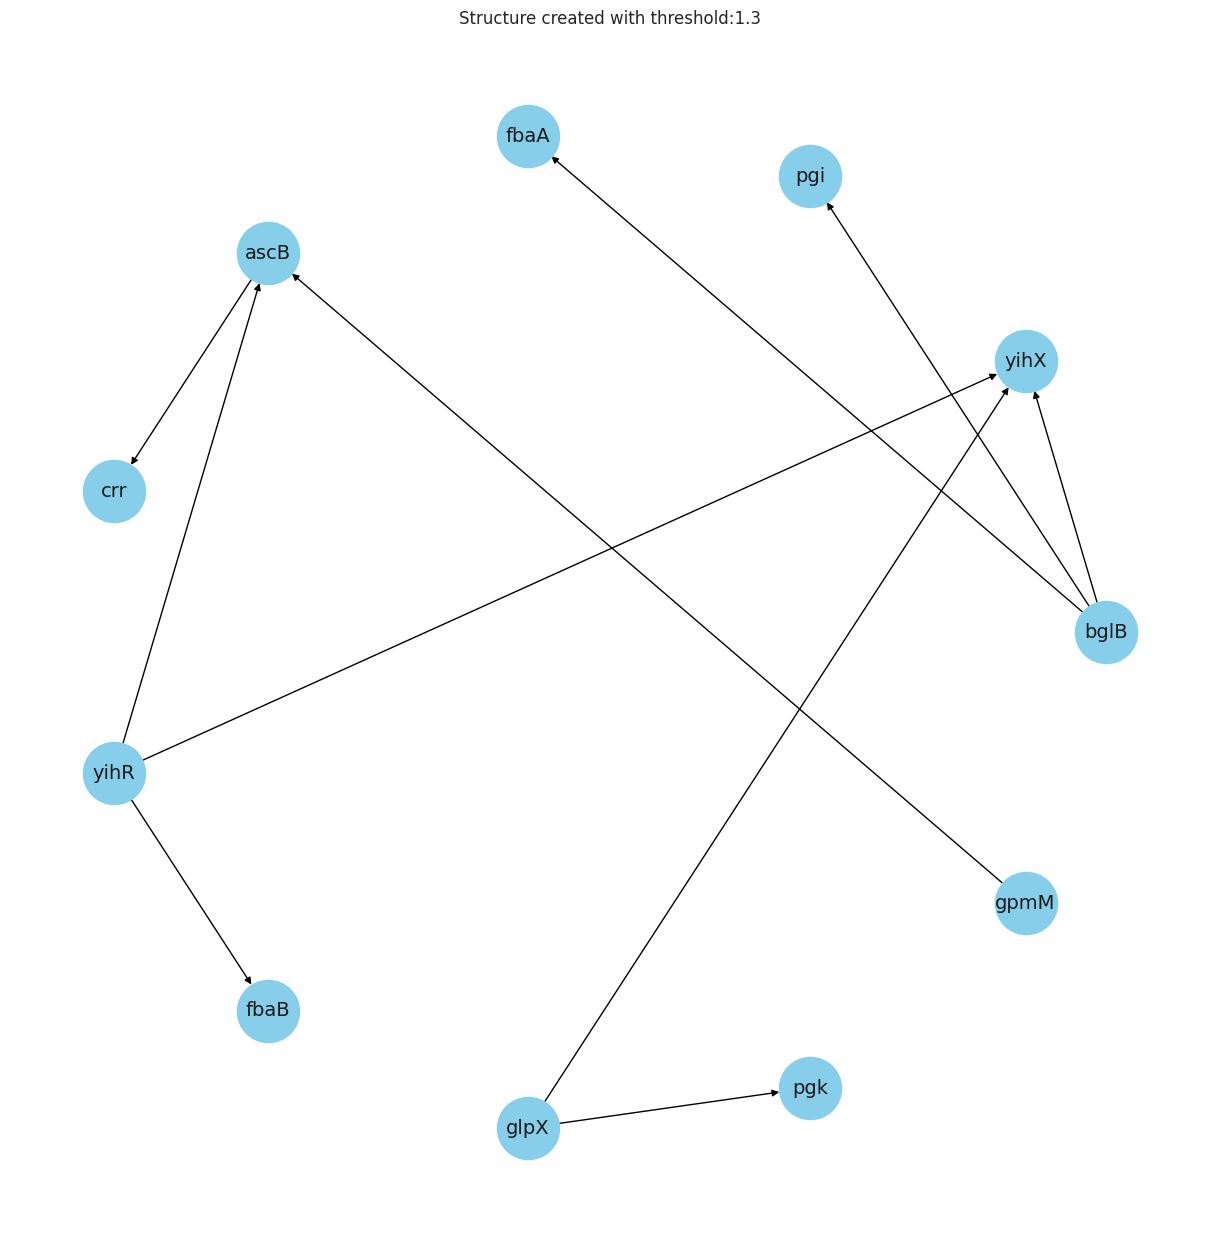

In [46]:
train, test = train_test_split(discretised_data, train_size=0.6, random_state=42)

beta=best_params['beta']
max_iter=1000       # 一旦1000で固定
w_threshold=1.3
# w_threshold=1


result_tuple = from_pandas_lasso(X=norm_data, 
                                 beta=beta, 
                                 max_iter=max_iter, 
                                 w_threshold=w_threshold)
sm, loss_values = result_tuple

# 損失関数で計算した値を出力
print(loss_values)

# エッジが伸びていないノードを排除, 関係性の強いエッジを太くする
edge_width = [d["weight"]*1 for (u, v, d) in sm.edges(data=True)]
# 上記の処置を施したものを新たなグラフとして保存, 複数あるうち最大のグラフを抜擢
sm = sm.get_largest_subgraph()
# DAGになるように閾値を上げる
sm.threshold_till_dag()

# 構造モデルの出力
print("構造モデル:", sm)
print('-'*50)

# 構造モデルのノードとエッジを出力
print('ノード:', sm.nodes())
print('エッジの組み合わせ: ', sm.edges())

# 連番生成関数
def create_filename(base_name, directory='.', extension='.png'):
    counter = 1
    while True:
        file_name = f"{base_name}_{counter}{extension}"
        full_path = os.path.join(directory, file_name)
        if not os.path.exists(full_path):
            return full_path
        counter += 1

# グラフ描画関数
def draw_graph(sm, w_threshold):
    sns.set(style="whitegrid")

    # 構造モデルsmをnetworkxのグラフに変換
    G = nx.DiGraph(sm.edges())

    # グラフの描画
    plt.figure(figsize=(12, 12))
    pos = nx.circular_layout(G)  # ノードの配置
    nx.draw(G, pos, with_labels=True, node_size=2000, edge_color="black", node_color="skyblue", font_size=14)
    plt.title(f"Structure created with threshold:{w_threshold}")
    plt.savefig(f"./bio_networks/bio_network_th{w_threshold}.png", format="png", dpi=300, bbox_inches='tight')
    return w_threshold

w_threshold = draw_graph(sm, w_threshold)

- sm = sm.get_largest_subgraph()の部分で，複数生成されるグラフの中から最大のグラフをサブグラフとして認識し，構造モデルとして更新する
- 目的1: ベイジアンネットワークを組む時に，1つのモデルである必要がある
- 目的2: ネットワークの中核となるノード・エッジの理解
- 島同士が同じエッジの数・ノードの数でも表示に優劣が出る理由: for文で最初にピックアップしたもの以上のもので更新されるため，最初に採択されたグラフを採択することになる

-> from_pandas_lassoでの学習は，再現性があり，正しく学習できていることになる!あとは表示の仕方(BNに使用するグラフをどう選ぶか・何基準で選ぶか)の問題...

In [47]:
bn = BayesianNetwork(sm)

bn = bn.fit_node_states(train)
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

# AUCを計算
for i, v in enumerate(sm.nodes()):
    _, auc = roc_auc(bn, test, v)
    print(f"\n{v}'s AUC: {auc}") 

/home/yarita/.local/lib/python3.9/site-packages/causalnex/network/network.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map(self._node_states[col])
/home/yarita/.local/lib/python3.9/site-packages/causalnex/network/network.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map(self._node_states[col])
/home/yarita/.local/lib/python3.9/site-packages/causalnex/network/network.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

ValueError: Found input variables with inconsistent numbers of samples: [170, 85]

In [48]:
# CPDの値をフィルタリングする関数
def filter_cpd_values(cpd, filter_value=0.0):
    filtered_cpd = cpd[(cpd != filter_value).any(axis=1)]
    filtered_cpd = filtered_cpd.loc[:, (filtered_cpd != filter_value).any(axis=0)]
    return filtered_cpd

# 各ノードのフィルタリングされたCPDを保存する辞書を初期化
filtered_cpds = {}

# すべてのノードに対してフィルタリングを行い、結果を辞書に保存
for node in sm.nodes():
    cpd = bn.cpds[node]
    filtered_cpds[node] = filter_cpd_values(cpd)

# すべてのフィルタリングされたCPDを1つのExcelファイルに保存
with pd.ExcelWriter(f'filtered_cpds_th{w_threshold}.xlsx') as writer:
    for node, cpd in filtered_cpds.items():
        cpd.to_excel(writer, sheet_name=node)